
#**Will Your App be a Success in the Google Play Store?**

---

### Links:

To Blog: [Will Your App be a Success in the Google Play Store? (Using Machine Learning to Predict Ratings)](https://ashley-brooks.medium.com/will-your-app-be-a-success-in-the-google-play-store-108c690f1421)

To GitHub: [Repository](https://github.com/AshleyBrooks213/ds21_bw2)


In [1]:
%%capture
import pandas as pd

#Import dataset and set index to 'Last Updated'
df = pd.read_csv('googleplaystore.csv',
                 index_col='Last Updated')
#Import libraries that are not incuded with Colab
!pip install category_encoders==2.*
!pip install pandas-profiling==2.*
!pip install pdpbox
!pip install shap



In [2]:
#In order of use:
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from category_encoders import OrdinalEncoder
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline 
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot
from sklearn.metrics import classification_report, plot_confusion_matrix, plot_roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score
import shap
import numpy as np

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [3]:
print(df.shape)
df.head(2)


(10841, 12)


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Current Ver,Android Ver
Last Updated,,,,,,,,,,,,
"January 7, 2018",Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,1.0.0,4.0.3 and up
"January 15, 2018",Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,2.0.0,4.0.3 and up


In [4]:
#Plotly Express scatter plot of Category vs Price
##Showing the outliers
fig = px.scatter(df, x='Category', y='Price', title='Cost of Apps per Category')


fig.show()

In [5]:
# Get Pandas Profiling Report
#import pandas_profiling

#df.profile_report()

#I. Wrangle Data

*    Make copy of dataset
*    Replace '_' wiht ''in column names
*    Remove the null value in 'Content_Rating' (This must be done in order to parse dates. This row has weird and misplaced values.)
*    Parse index dates
*    Remove '$' in 'Price' and replace with ''. Then, set type to float.
*    Replace the names of 'Apps' with the number of words in each name
*    Remove rows with no targets in target column
*    Feature engineer a new column that is our binary classification target
*    Remove high cardinal categorical columns
*    Remove the columns 'Installs' so as to prevent leakage.
*    Remove outliers in the 'Price' column
*    Will need SimpleImputer and OrdinalEncoder later on


In [6]:
def wrangle(X):
  #Make a copy
  X = X.copy()

  #Change column names by replacing (' ') with ('_')
  X.columns = X.columns.str.replace(' ', '_')

  #Drop row with null value in 'Content_Rating'
  #This row had a lot of misplaced and weird values
  ##This has to be done before we can parse dates
  X.dropna(subset=['Content_Rating'], inplace=True)

  #pd.to_datetime dates in datetime index
  #This will work now that we have removed that row
  X.index = pd.to_datetime(X.index)

  #Change 'Price' from an object to a float 
  #Remove '$'
  X['Price'] = X['Price'].str.replace('$', '').astype(float)
  
  #Replace the names of apps with the number of words in each name
  X['App'] = X['App'].apply(lambda s: len(s.split(' ')))
  
  #Remove rows with no targets in target column
  X.dropna(subset=['Rating'], inplace=True)

  #Feature Engineer new target column
  X['Successful_Rating'] = X['Rating'] >= 4

  #Drop 'Rating' so as to avoid leakage
  X.drop(columns='Rating', inplace=True)

  #Remove high cardinality categorical columns
  high_card_col = [col for col in X.select_dtypes('object').columns
                   if X[col].nunique() > 50]
  X.drop(columns=high_card_col, inplace=True)

  #Remove 'Installs' because we don't want leakage
  X.drop(columns='Installs', inplace=True)

  #Remove 'Price' outliers > 100.0
  outliers = X['Price'] > 100.0
  X=X[~outliers]
  

  return X

In [7]:
#Wrangle df
df = wrangle(df)

print(df.shape)
df.head()

(9351, 7)


,App,Category,Type,Price,Content_Rating,Android_Ver,Successful_Rating
Last Updated,,,,,,,
2018-01-07,9,ART_AND_DESIGN,Free,0.0,Everyone,4.0.3 and up,True
2018-01-15,3,ART_AND_DESIGN,Free,0.0,Everyone,4.0.3 and up,False
2018-08-01,10,ART_AND_DESIGN,Free,0.0,Everyone,4.0.3 and up,True
2018-06-08,5,ART_AND_DESIGN,Free,0.0,Teen,4.2 and up,True
2018-06-20,7,ART_AND_DESIGN,Free,0.0,Everyone,4.4 and up,True


In [8]:
#Plotly Express scatter plot of Category vs Price
##AFTER removing outliers
fig = px.scatter(df, x='Category', y='Price', title='Cost of Apps per Category')


fig.show()

In [9]:
#Date range of df

print('Index Date min:', df.index.min())
print('Index Date Max:', df.index.max())

Index Date min: 2010-05-21 00:00:00
Index Date Max: 2018-08-08 00:00:00


In [10]:
# What is the maximum Price for an App?
print(df['Price'].sort_values(ascending=False))
df['Price'].max()

Last Updated
2018-06-18    79.99
2018-06-18    79.99
2018-04-04    39.99
2017-07-18    37.99
2017-10-02    33.99
              ...  
2015-04-20     0.00
2018-01-13     0.00
2018-05-30     0.00
2016-06-30     0.00
2018-01-07     0.00
Name: Price, Length: 9351, dtype: float64


79.99

In [11]:
# The row that contains the max Price for an app
df.sort_values(by=['Price']).max()

App                       26
Category             WEATHER
Type                    Paid
Price                  79.99
Content_Rating       Unrated
Successful_Rating       True
dtype: object

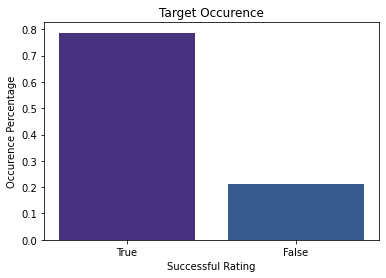

In [12]:
#Bar Chart that shows how imbalanced the dataset is
import matplotlib.pyplot as plt
import seaborn as sns
plt.bar(['True', 'False'], df['Successful_Rating'].value_counts(normalize=True),
        color=sns.color_palette("viridis"))
plt.title('Target Occurence')
plt.ylabel('Occurence Percentage')
plt.xlabel('Successful Rating')
plt.show();



In [13]:
#Actual percentages of each class
df['Successful_Rating'].value_counts(normalize=True)

True     0.787189
False    0.212811
Name: Successful_Rating, dtype: float64

#II. Split Data
*    Check proportion of classes

**Split Target Vector from Feature Matrix**

In [14]:
target = 'Successful_Rating'
y = df[target]
X=df.drop(columns=target)

**Train / Test Split**

In [15]:
#Split train and test sets
#Train, test timeseries split(80/20)
len(X) * 0.8
cutoff = 7480
X_train, y_train = X.iloc[:cutoff], y.iloc[:cutoff]
X_test, y_test = X.iloc[cutoff:], y.iloc[cutoff:]

len(X_train) * 0.8

5984.0

**Train / Validation Split**

In [16]:
#Split train and validation sets 
#Train, validation timeseries split (80/20)
len(X_train) * 0.8
cutoff2 = 5984

X_train2, y_train2 = X_train.iloc[:cutoff2], y_train.iloc[:cutoff2]
X_val, y_val = X_train.iloc[cutoff2:], y_train.iloc[cutoff2:]


**Balance Data Using SMOTE**

*    **Use OrdinalEncoder and SimpleImputer (replace categorical variables with integers and remove NaN values in order to use SMOTE)**
*    **Fit, transform training and validation sets**
*    **Transform test sets only (so as not to retrain)**
*    **Resample our new OrdinallyEncoded and SimpleImputed training, validation, and test sets**



In [17]:
#Instantiate SMOTE
method = SMOTE(random_state=42)

#Instantiate OrdinalEncoder
##Fit and transform X_train
###Transform X_val and X_test (Do not fit validation and test sets)
oe = OrdinalEncoder()
XT_train = oe.fit_transform(X_train2)
XT_val = oe.transform(X_val)
X_test_oe = oe.transform(X_test)

#Instantiate SimpleImputer 
## Fit and transform XT_train
###Transform X_val and X_test_oe (Do not fit val and test sets)
si = SimpleImputer()
XTT_train = si.fit_transform(XT_train)
XTT_val = si.transform(XT_val)
X_test_oesi = si.transform(X_test_oe)

#Resample XTT_train and y_train using SMOTE
X_resampled, y_resampled = method.fit_sample(XTT_train, y_train2)

#Resample XTT_val and y_val using SMOTE
X_val_res, y_val_res = method.fit_sample(XTT_val, y_val)

#Resample X_test_oesi and y_test using SMOTE
X_test_resamp, y_test_resamp = method.fit_sample(X_test_oesi, y_test)

**Shape of target now that the data has been balanced**

In [18]:
#Use Counter and print how many values there are now
#Now we have a balanced dataset (with synthetic values for the minority class) 
cy = Counter(y_resampled)
print(f'Resampled dataset shape "{cy}".')



Resampled dataset shape "Counter({True: 4952, False: 4952})".


*    **See how imbalanced the dataset used to be**

In [19]:
#Check how imbalanced the dataset is
##Also done above a different way
print('Proportion of classes in the data:',
      df['Successful_Rating'].value_counts() / len(df))

Proportion of classes in the data: True     0.787189
False    0.212811
Name: Successful_Rating, dtype: float64


**Convert Target training and validation sets to a Pandas Series (some functions will only work when the data in this format)**

In [20]:
#Convert y_resampled to a Pandas Series
y_resampled_s=pd.Series(y_resampled)

#Convert y_val_res to a Pandas Series
y_val_res_s=pd.Series(y_val_res)

#Convert y_test_resamp to a Pandas Series
y_test_resamp_s = pd.Series(y_test_resamp)

print(type(y_resampled_s))
print(type(y_val_res_s))
print(type(y_test_resamp_s))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


**Convert training, validation, and test feature matrices to a DataFrame (some functions will only work when the data is in this format)**

In [21]:
#Convert X_resampled to a DataFrame
X_resampled_s = pd.DataFrame(X_resampled, 
                             columns=['App', 'Category', 'Type', 'Price', 'Content_Rating', 'Android_Ver'])

#Convert X_val_res to a DataFrame
X_val_res_s=pd.DataFrame(X_val_res, 
                         columns=['App', 'Category', 'Type', 'Price', 'Content_Rating', 'Android_Ver'])

#Convert X_test_resamp to a DataFrame
X_test_resamp_s = pd.DataFrame(X_test_resamp, 
                               columns=['App', 'Category', 'Type', 'Price', 'Content_Rating', 'Android_Ver'])


print(type(X_resampled_s))
print(type(X_val_res_s))
print(type(X_test_resamp_s))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


#III. Establish Baseline

In [22]:
#As expected our Baseline Accuracy is a coin flip
##That's because our target's classes have an equal amount of variables
print('Baseline Accuracy:', y_resampled_s.value_counts(normalize=True).max())

Baseline Accuracy: 0.5


#IV. Build Models
*    Random Forest Classifier
*    Gradient Boosting Classifier
*    XGBoost Classifier
*    Logistic Regression


**Random Forest Classifier**

>Tuned using GridSearchCV (see below)

In [23]:
model_rf = RandomForestClassifier(n_estimators=20,
                                  max_depth=5,
                                  max_samples=0.2,
                                  random_state=42,
                                  n_jobs=-1)


model_rf.fit(X_resampled_s, y_resampled_s);

**Gradient Boosting Classifier**

> I did the hyperparameter tuning by hand for this model.

>If you decrease learning_rate and increase n_estimators, you get better performance. 



In [24]:
model_skgb = GradientBoostingClassifier(random_state=42,
                                        learning_rate=0.005, 
                                        n_estimators=1600,
                                        max_depth=9,
                                        min_samples_split=1200, 
                                        min_samples_leaf=60, 
                                        subsample=0.85)

model_skgb.fit(X_resampled_s, y_resampled_s);

**XGBClassifier**

>I did the hyperparameter tuning by hand for this model, as well.

>The number of estimators and max_depth is significantly less than the Gradient Boosting Classifier model.


In [25]:
eval_set = [(X_val_res_s, y_val_res_s)]

model_xgb = XGBClassifier(n_estimators=500,                          
                          learning_rate=0.05,
                          random_state=42,
                          eval_set=eval_set,
                          max_depth=3,
                          eval_metric='merror',
                          early_stopping_rounds=10,
                          verbose=True,
                          n_jobs=-1)

model_xgb.fit(X_resampled_s, y_resampled_s);

**Logistic Regression**

>There was no hyperparameter tuning done with this model

In [26]:
model_lr = LogisticRegression()


model_lr.fit(X_resampled_s, y_resampled_s);

#V. Check Metrics

*    Random Forest Classifier

*    Gradient Boosting Classifier

*    XGBoost 

*    Logistic Regression

In [27]:
#RandomForestClassifier Training and Validation Accuracy:
print('RandomForestClassifier Training Accuracy:', model_rf.score(X_resampled_s, y_resampled_s).max())
print('RandomForestClassifier Validation Accuracy:', model_rf.score(X_val_res_s, y_val_res_s).max())
print()
#GradientBoostingClassifier Training and Validation Accuracy:
print('GradientBoostingClassifier Training Accuracy:', model_skgb.score(X_resampled_s, y_resampled_s))
print('GradientBoostingClassifier Validation Accuracy:', model_skgb.score(X_val_res_s, y_val_res_s))
print()
#XGBoost Training and Validation Accuracy:
print('XGBoost Training Accuracy:', model_xgb.score(X_resampled_s, y_resampled_s))
print('XGBoost Validation Accuracy:', model_xgb.score(X_val_res_s, y_val_res_s))
print()
#Logistic Regression Training and Validation Accuracy:
print('LogisticRegression Training Accuracy:',model_lr.score(X_resampled_s, y_resampled_s).max())
print('LogisticRegression Validation Accuracy:', model_lr.score(X_val_res_s, y_val_res_s).max())

RandomForestClassifier Training Accuracy: 0.7050686591276252
RandomForestClassifier Validation Accuracy: 0.6574074074074074

GradientBoostingClassifier Training Accuracy: 0.8165387722132472
GradientBoostingClassifier Validation Accuracy: 0.7347222222222223

XGBoost Training Accuracy: 0.8260298869143781
XGBoost Validation Accuracy: 0.7337962962962963

LogisticRegression Training Accuracy: 0.5903675282714055
LogisticRegression Validation Accuracy: 0.5916666666666667


#**Classification Report**

*     Gradient Boosting Classifier

*     XGBoosting Classifier

>**compared to the worst performing model(in this case):**

*     Logistic Regression

**Gradient Boosting Classifier**

In [28]:
#Gradient Boosting Classifier
#The Recall score for False values is still lower,
##but it is better than what it was.

#We have better Recall scores for True values and 
##better Precision scores for False values

#With f1-scores of 0.72 and 0.75, I don't think our model is too bad.

print('Gradient Boosting Classifier')
print(classification_report(y_val_res_s, model_skgb.predict(X_val_res_s)))


Gradient Boosting Classifier
              precision    recall  f1-score   support

       False       0.76      0.68      0.72      1080
        True       0.71      0.79      0.75      1080

    accuracy                           0.73      2160
   macro avg       0.74      0.73      0.73      2160
weighted avg       0.74      0.73      0.73      2160



**XGBoost Classifier**

In [29]:
#XGBoost Classifier
##I think this model is the best

print('XGBClassifier')
print(classification_report(y_val_res_s, model_xgb.predict(X_val_res_s)))

XGBClassifier
              precision    recall  f1-score   support

       False       0.75      0.70      0.73      1080
        True       0.72      0.77      0.74      1080

    accuracy                           0.73      2160
   macro avg       0.73      0.73      0.73      2160
weighted avg       0.73      0.73      0.73      2160



**Logistic Regression**

In [30]:
#Logistic Regression
##Worst performing model

print('LogisticRegression')
print(classification_report(y_val_res_s, model_lr.predict(X_val_res_s)))

LogisticRegression
              precision    recall  f1-score   support

       False       0.58      0.69      0.63      1080
        True       0.61      0.49      0.55      1080

    accuracy                           0.59      2160
   macro avg       0.60      0.59      0.59      2160
weighted avg       0.60      0.59      0.59      2160



#**Confusion Matrix**

> For Gradient Boosting Classifier & XGBoost

**Gradient Boosting Classifier**

>This model has a low number of False Negatives and False Positives!

>This model predicted 740 True Negatives and 840 True Positives!

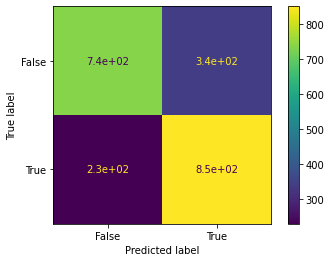

In [31]:
#TN = 740
#FP = 340
#FN = 240
#TP = 840
##This model has a low number of both False Positives and False Negatives
plot_confusion_matrix(model_skgb, X_val_res_s, y_val_res_s);

**XGBoost Classifier**

>This model predicted a low number of False Negatives and False Positives!

>This model predicted 760 True Negatives and 830 True Positives!

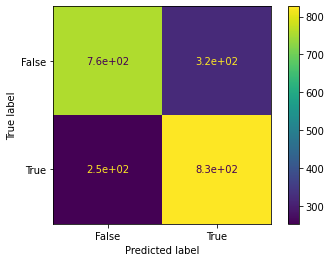

In [32]:
#TN = 760
#FP = 320
#FN = 250
#TP = 830
##This model also has a low number of both FP and FN
plot_confusion_matrix(model_xgb, X_val_res_s, y_val_res_s);

#VI. Tune Models 
*    Performed a GridSearchCV on RandomForestClassifier to tune its' hyperparameters in order to try to improve model performance.

*    Gradient Boosting Classifier and XGBoost Classifier are still the better models.

*    I tuned Gradient Boosting Classifier and XGBoost by hand.

#**GridSearchCV for RandomForestClassifier**

In [33]:
pipeline = make_pipeline(
    RandomForestClassifier(random_state=42,
                           n_jobs=-1)
)

In [34]:
params = {
    'randomforestclassifier__max_depth' : range(5, 100, 500),
    'randomforestclassifier__n_estimators' : [15, 20, 75],
    'randomforestclassifier__max_samples' : np.arange(0.2, 0.6, 0.8)
}

In [35]:
model = GridSearchCV(pipeline,
                     param_grid=params,
                     cv=5,
                     n_jobs=-1,
                     verbose=1)

model.fit(X_resampled_s, y_resampled_s)

model.best_params_
model.best_score_
model.best_estimator_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    4.0s finished


Pipeline(memory=None,
         steps=[('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=5, max_features='auto',
                                        max_leaf_nodes=None, max_samples=0.2,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=20, n_jobs=-1,
                                        oob_score=False, random_state=42,
                                        verbose=0, warm_start=False))],
         verbose=False)

#**ROC Curve**

- To evaluate the models used for our binary classification problem.


**ROC Curve for LogisticRegression and RandomForestClassification models** (Least performing models)

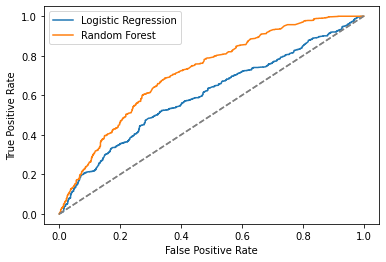

In [36]:
#ROC curve 
##Evaluating LogisticRegression and RandomForestClassifier
###Least performing models

lr = plot_roc_curve(model_lr, 
                    X_val_res, 
                    y_val_res, 
                    label='Logistic Regression')
rf = plot_roc_curve(model_rf, 
                    X_val_res, 
                    y_val_res, 
                    ax=lr.ax_, 
                    label='Random Forest')
plt.plot([(0,0), (1,1)], color='grey', linestyle='--')
plt.legend();


**ROC Curve for XGBoost Classifier and GradientBoostingClassifier models** (Best performing models)

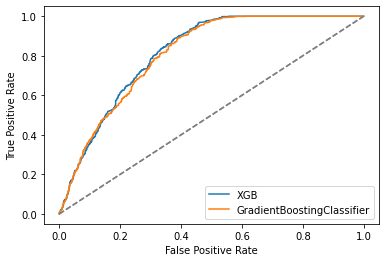

In [37]:
#ROC curve
##Evaluating models XGBoost and GradientBoostingClassifier

xgb = plot_roc_curve(model_xgb, X_val_res_s, y_val_res_s, label='XGB')
gradientboostclass = plot_roc_curve(model_skgb, X_val_res_s, y_val_res_s,
                                    ax=xgb.ax_, label='GradientBoostingClassifier')
plt.plot([(0,0), (1,1)], color='grey', linestyle='--')
plt.legend();

#Best Thresholds for GradientBoostingClassifier and XGBoost Classifier models

**GradientBoostingClassifier**

In [38]:
#I tuned model_skgb by hand
##Let's take a look at the best threshold is for the model

#GradientBoostingClassifier predicted probability
y_pred_prob_skgb = model_skgb.predict_proba(X_val_res_s)[:,-1]

#Create DataFrame with y validation values and the predicted probabilites
predictions1 = pd.DataFrame({'y_val': y_val_res_s,
                            'y_pred_prob': y_pred_prob_skgb})


In [39]:
#set range of thresholds (anything below 0.5 is bad)
##and create empty lists for our accuracy, precision, and recall
###for GradientBoostingClassification model
thresholds = np.arange(0.05, 1, 0.05)
accuracy = []
precision = []
recall = []

for threshold in thresholds:
    predictions1['y_pred_1'] = (predictions1['y_pred_prob'] > threshold).astype(int)
    accuracy.append(accuracy_score(predictions1['y_val'], predictions1['y_pred_1']))
    precision.append(precision_score(predictions1['y_val'], predictions1['y_pred_1']))
    recall.append(recall_score(predictions1['y_val'], predictions1['y_pred_1']))

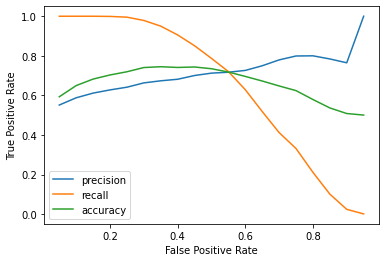

In [40]:
#Best threshold for GradientBoostingClassification model
plt.plot(thresholds, precision, label='precision')
plt.plot(thresholds, recall, label='recall')
plt.plot(thresholds, accuracy, label='accuracy')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend();

**XGBoost Classifier**

In [41]:
#I tuned model_xgb by hand
##Let's take a look at the best threshold is for the model

#XGBoost Classifier predicted probability
y_pred_prob_xgb = model_xgb.predict_proba(X_val_res_s)[:,-1]

#Create DataFrame with y validation values and the predicted probabilites
predictions2 = pd.DataFrame({'y_val' : y_val_res_s,
                            'y_pred_prob2' : y_pred_prob_xgb})

In [42]:
#set range of thresholds (anything below 0.5 is bad)
##and create empty lists for our accuracy, precision, and recall
###for XGBoost Classifier model
thresholds = np.arange(0.05, 1, 0.05)
accuracy = []
precision = []
recall = []

for threshold in thresholds:
    predictions2['y_pred_2'] = (predictions2['y_pred_prob2'] > threshold).astype(int)
    accuracy.append(accuracy_score(predictions2['y_val'], predictions2['y_pred_2']))
    precision.append(precision_score(predictions2['y_val'], predictions2['y_pred_2']))
    recall.append(recall_score(predictions2['y_val'], predictions2['y_pred_2']))

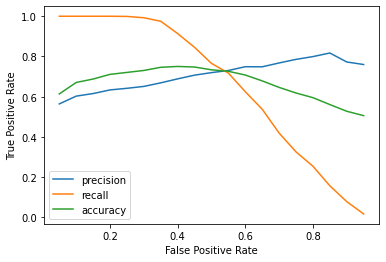

In [43]:
#Best threshold for XGBoost Classifier model
plt.plot(thresholds, precision, label='precision')
plt.plot(thresholds, recall, label='recall')
plt.plot(thresholds, accuracy, label='accuracy')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend();

#VII. Communicate Results

#Feature Importances

*  App, Type, and Content_Rating appear to be the most important features for model_xgb

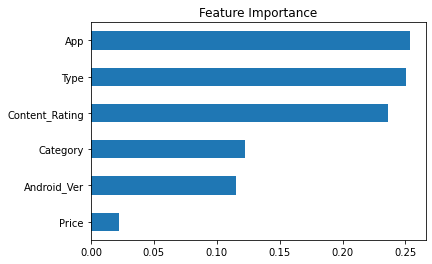

In [58]:
importances = pd.Series(model_xgb.feature_importances_, X_resampled_s.columns).sort_values(ascending=True)
plt.figure
plt.title('Feature Importance')
importances.plot.barh();

#**Partial Dependence Plot (PDP Plot)**

>One feature 'Price'

>Two feature 'App' and 'Price'

*    (always use validation set)


**Isolate PDP Plot**

>Using Gradient Boosting Classifier

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


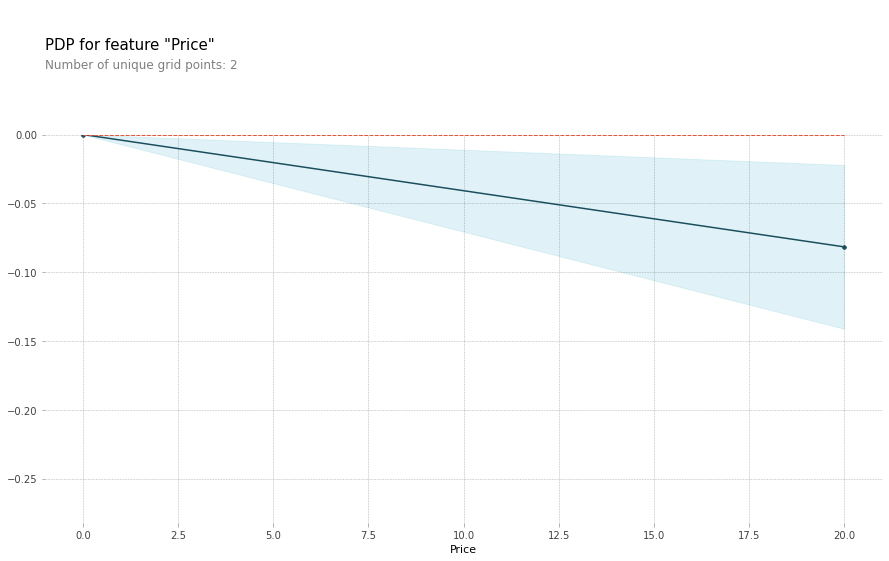

In [44]:
#Create Isolate PDP Plot 
##For Gradient Boosting Classifier

feature = 'Price'

# Isolate
isolate = pdp_isolate(
    model=model_skgb,
    dataset=X_val_res_s, 
    model_features=X_val_res_s.columns,
    feature=feature
)

pdp_plot(isolate, feature_name=feature);

**PDP Interact Plot**

>Using XGBoost Classifier

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


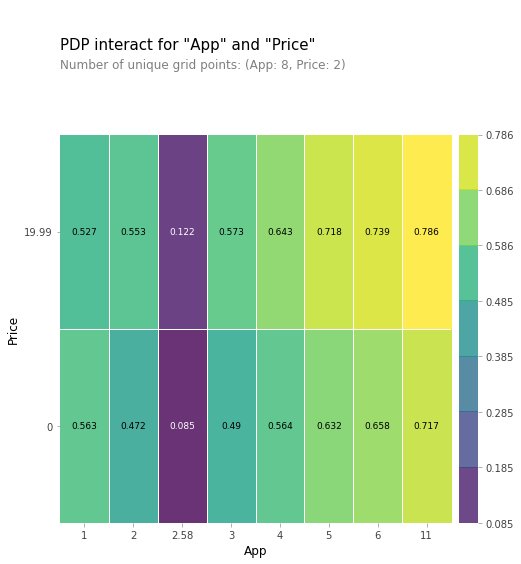

In [45]:
#Create PDP Interact Plot
##For XGBoost Classifier

features = ['App', 'Price']

interact = pdp_interact(
    model= model_xgb,
    dataset=X_val_res_s,
    model_features=X_val_res_s.columns,
    features=features
)

pdp_interact_plot(interact, plot_type='grid', feature_names=features);



#Shapley

*    Shows the influence of features on an *individual* prediction using Gradient Boosting Classifier model

In [46]:
# Grab a single observation from test data
row = X_test_resamp_s.iloc[[25]]
row

,App,Category,Type,Price,Content_Rating,Android_Ver
25,2.0,5.0,1.0,0.0,1.0,6.0


In [47]:
# What the XGB Classifier model predicted for row
model_xgb.predict(row)

array([ True])

>'Category=5', 'Content_Rating=1', and 'Android_Ver=6' have a positive impact on this single prediction
*    'Android_Ver=6' has the best impact 

>'App=2' and 'Type=1' have a negative impact on this single prediction
*    'App=2' has the worst impact 

In [48]:
#model_xgb =! a pipeline

explainer = shap.TreeExplainer(model_xgb) 

shap.initjs()

shap.force_plot(
    base_value=explainer.expected_value[0],
    shap_values=explainer.shap_values(row)[0],
    features=row
    )

In [49]:
#row[1]
##Can also look at row[0]
#explainer.shap_values(row)[1]

In [50]:
#Expected value has 2 values (0,1)
#explainer.expected_value

#**Predictions**

>For all models

**XGBoost Classifier**

>Appears to be the best performing model

In [51]:
#XGBoost Classifier target prediction

y_pred_xgb = model_xgb.predict(X_test_resamp_s)

print("XGBoost Classifier Test Accuracy:", model_xgb.score(X_test_resamp_s, y_test_resamp_s))

XGBoost Classifier Test Accuracy: 0.7061700526711814


**Gradient Boosting Classifier**

In [52]:
#GradientBoostingClassifier target prediction
y_pred_skgb = model_skgb.predict(X_test_resamp_s)

print("Gradient Boosting Test Accuracy:", model_skgb.score(X_test_resamp_s, y_test_resamp_s))


Gradient Boosting Test Accuracy: 0.7050413844996237


**Random Forest Classifier**

In [53]:
#RandomForestClassifier target prediction
y_pred_rf = model_rf.predict(X_test_resamp_s)

print("Random Forest Classifier Test Accuracy:", model_rf.score(X_test_resamp_s, y_test_resamp_s))

Random Forest Classifier Test Accuracy: 0.6192626034612491


**Logistic Regression**

>Even though this model has the worst performance, it is still beating the Baseline.

In [54]:
#LogisticRegression target prediction
y_pred_lr = model_lr.predict(X_test_resamp_s)

print("Logistic Regression Test Accuracy:", model_lr.score(X_test_resamp_s, y_test_resamp_s))

Logistic Regression Test Accuracy: 0.5752445447705041
